In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#Pytorch paper replicating
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py .
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
    !rm -rf pytorch-deep-learning

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1457), reused 1401 (delta 1401), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 44.50 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# Get Data
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                          destination = "pizza_steak_sushi")

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


In [6]:
image_path

PosixPath('data/pizza_steak_sushi')

In [7]:
train_dir = image_path/"test"
test_dir = image_path/"train"



In [8]:
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/test'),
 PosixPath('data/pizza_steak_sushi/train'))

In [9]:
# Create Datasets and Dataloaders
from going_modular.going_modular import data_setup

#Create image size
IMG_SIZE = 224

#Create transforms pipeline
manual_transforms = transforms.Compose([transforms.Resize(size = (IMG_SIZE,IMG_SIZE)),
                                       transforms.ToTensor()])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [10]:
#Create a batch size of 32(the paper use 4096 but this may be too big for our smaller hardware.. can always scaleup later)
BATCH_SIZE = 32

#Create DataLoaders
train_dataloader,test_dataloader,class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                            test_dir = test_dir,
                                                                            transform = manual_transforms,
                                                                            batch_size = BATCH_SIZE)

len(train_dataloader),len(test_dataloader),class_names

(3, 8, ['pizza', 'steak', 'sushi'])

In [11]:
# Visualize a single image

#Get a batch of image
image_batch,label_batch = next(iter(train_dataloader))

#Get a single image and label from the batch
image,label = image_batch[0],label_batch[0]

#View the single image and label shapes
image.shape, label



(torch.Size([3, 224, 224]), tensor(2))

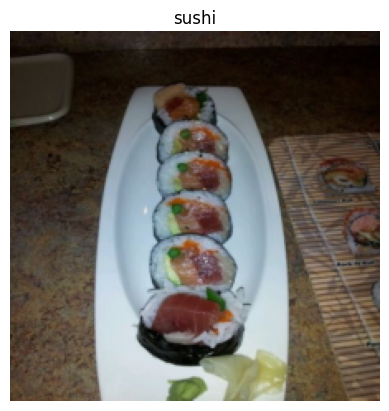

In [12]:
#Plot the image with matplotlib

import matplotlib.pyplot as plt
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [13]:
# Replicating ViT: Overview